## Семинар 4: "Сверточные сети"

ФИО: Личманов Дмитрий Игоревич

In [7]:
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
import torch
from torch import nn
from torch.autograd import Variable
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
from IPython.display import clear_output
%matplotlib inline

### Часть 1: Свертка

#### Одномерные сигналы
Начнем с одномерных сигналов — например, это могут быть различные временные ряды. 

<i>1.1 Реализуйте функцию, вычисляющую одномерную свертку.</i>

In [32]:
def t_convolve(signal, kernel):
    signal_convolved = np.zeros(len(signal)-len(kernel)+1)
    for i in range(signal_convolved.shape[0]):
        signal_convolved[i] = np.sum(signal[i:i+kernel.size] * kernel[::-1])
    return signal_convolved

Проверим правильность реализации, сравнив с реализацией из scipy

In [33]:
from scipy.signal import convolve

signal = np.random.rand(100)
kernel = np.random.rand(5)
t_result = t_convolve(signal, kernel)
b_result = convolve(signal, kernel, mode='valid')

np.testing.assert_allclose(t_result, b_result)

Посмотрим как операция свертки может помочь нам убрать шум из сигнала

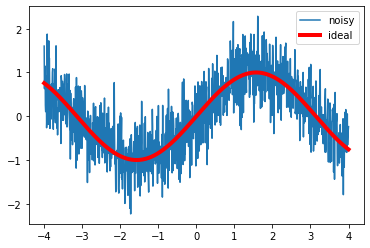

In [34]:
x = np.linspace(-4, 4, 1000)
signal = np.sin(x)
noisy_signal = signal + np.random.randn(signal.shape[0])*0.5
plt.plot(x, noisy_signal, label='noisy')
plt.plot(x, signal, 'r', label='ideal', linewidth=4)
plt.legend(loc=0)

Для подавления шума можно использовать усреднение значений сигнала в окрестности каждой точки (см. ЗБЧ). Вы можете убедиться, что такая операция может быть реализована при помощи свертки данных с ядром, $[\frac 1w, \frac 1w, ..., \frac 1w]$, где $w$ — размер окна.

<i>1.2  Вычислите свертку <b>зашумленного</b> сигнала с ядром $[0.2, 0.2, 0.2, 0.2, 0.2]$ </i>

In [35]:
kernel_size = 5
kernel = np.ones(kernel_size)/kernel_size
denoised_signal = convolve(noisy_signal, kernel, 'same')

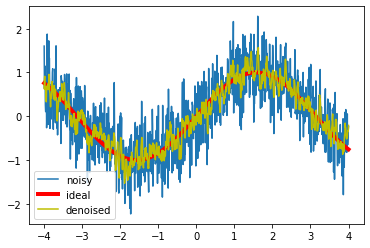

In [36]:
x = np.linspace(-4, 4, 1000)
plt.plot(x, noisy_signal, label='noisy')
plt.plot(x, signal, 'r', label='ideal', linewidth=4)
plt.plot(x, denoised_signal, 'y', label='denoised')
plt.legend(loc=0)

Заметим, что уровень шума значительно снизился! Попробуйте подобрать такую ширину окна, чтобы востановленный сигнал был наиболее похож на исходный.

<i> 1.3 Подберите размер окна <i>

In [37]:
best_diff = None

for kernel_size in range(2, 500):
    kernel = np.ones(kernel_size)/kernel_size
    denoised_signal = convolve(noisy_signal, kernel, 'same')
    dif = np.sqrt(np.mean((signal - denoised_signal)**2))
    if best_diff is None or best_diff[1] > dif:
        best_diff = (kernel_size, dif)

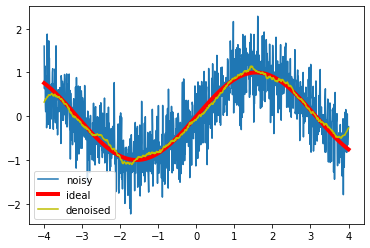

In [38]:
kernel_size = best_diff[0]
kernel = np.ones(kernel_size)/kernel_size
denoised_signal = convolve(noisy_signal, kernel, 'same')
x = np.linspace(-4, 4, 1000)
plt.plot(x, noisy_signal, label='noisy')
plt.plot(x, signal, 'r', label='ideal', linewidth=4)
plt.plot(x, denoised_signal, 'y', label='denoised')
plt.legend(loc=0)

#### Многомерные сигналы
Перейдем теперь к черно-белым и цветным изображениям. Для ЧБ изображений имеем двумерный сигнал, для цветных — трехмерный (высота x ширина x каналы).

Для цветных изображений количество каналов ядра обычно совпадает с количеством каналов изображения. Таким образом, в результате получается черно-белое изображение.

<i>Для вычисления многомерных сверток используйте функцию convolve из from scipy.signal import convolve</i>

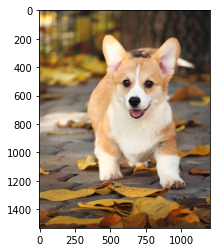

In [64]:
image = plt.imread('/content/korg_014.jpg')
plt.imshow(image)

<i>1.4 Найдите в вашей любимой поисковой системе веса каналов для перевода цветного изображения в черно-белое. Постройте фильтр, который будет переводить цветное изображение в ЧБ</i>

In [45]:
color_to_bw = np.array([0.2989, 0.5870, 0.1140]).reshape(1,1,3)

In [52]:
def image_convolve(image, kernel):
    image_convolved = np.zeros((image.shape[0] - kernel.shape[0] + 1, image.shape[1] - kernel.shape[1] + 1))
    for i in range(image_convolved.shape[0]):
        for j in range(image_convolved.shape[1]):
            image_convolved[i, j] = np.sum(image[i : i + kernel.shape[0], j : j + kernel.shape[1]] * kernel)
    return image_convolved

<i>1.5 На примере любого цветного изображения покажите результат его свертки с фильтром из предыдущего задания.</i>

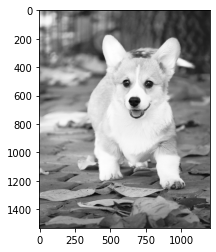

In [53]:
bw_image = image_convolve(image, color_to_bw)
plt.imshow(bw_image, cmap=plt.cm.Greys_r)

Операция свертки также позволяет находить границы на изображении. Для этого можно использовать, например, фильтр Собеля.

<i>1.6 Задайте ядро <a href="https://ru.wikipedia.org/wiki/Оператор_Собеля">фильтра Собеля</a> и продемонстрируйте результат его применения к любому цветному изображению.</i>

In [60]:
Gy = np.array([[-1, -2, -1],
                [0,   0,  0],
                [+1, +2, +1]]).reshape(3,3,1)
Gx = Gy.T.reshape(3,3,1)

In [57]:
bw_image[:,:,np.newaxis].shape

(1532, 1200, 1)

In [65]:
G = np.sqrt(image_convolve(image, Gy)**2 + image_convolve(image, Gx)**2)

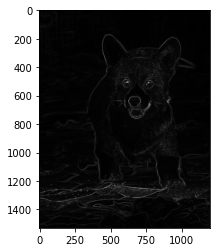

In [66]:
plt.imshow(G, cmap=plt.cm.Greys_r)

В сверточных нейронных сетях каждый слой использует несколько фильтров. Допустим, у нас было изображение с тремя каналами (количество входных каналов). Рассмотрим банк из четырех фильтров (количество выходных каналов). Тогда изначально будет вычислена свертка с каждым фильтром — получим 4 ЧБ изображения. Теперь соединим их в одно, интерпретируя каждое ЧБ изображение как канал цветного: RGB$\alpha$.

<i>1.7 Реализуйте операцию свертки с банком фильтров (filter bank).</i>

In [78]:
def t_convolve_bank(image, kernel):
    assert image.ndim == kernel.ndim - 1
    image_convolved = np.zeros((image.shape[0] - kernel.shape[1] + 1, image.shape[1] - kernel.shape[2] + 1, kernel.shape[0]))

    for channel in range(kernel.shape[0]):
        image_convolved[:, :, channel] = image_convolve(image, kernel[channel, :, :, :])
    
    return image_convolved

<i>1.8 Задайте банк фильтров, меняющий порядок следования каналов с RGB на BGR.</i>

In [73]:
kernel = np.array([
                   [0, 0, 1],
                   [0,1,0],
                   [1, 0, 0]
]).reshape(3,1,1,3)

<i>1.9 Продемонстрируйте результат свертки любого цветного изображения с банком фильтров из предыдущего пункта.</i>

In [79]:
res_img = t_convolve_bank(image, kernel)

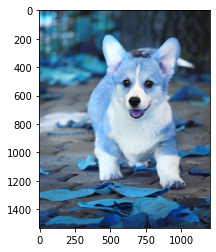

In [81]:
plt.imshow(res_img.astype('uint8'))

В процессе обучения сверточных нейронных сетей настраиваются веса элементов фильтр банка. Это позволяет не заниматься подбором коэффициентов "руками", а задавать лишь размер ядра: ширину, высоту, количество входных и выходных каналов. В итоге получаем четырехмерный массив (тензор).

### Часть 2: Пулинг

При использовании сверточных слоев принято использовать слои пулинга. Эта операция позволяет уменьшить пространственные размерности изображения и избавиться от избыточности.

<i>2.1 Реализуйте операции пулинга для цветных изображений</i>

In [ ]:
def maxpool(image, w=2):
    assert(image.ndim == 3)
    
    res = np.zeros((image.shape[0] // w, image.shape[1] // w, image.shape[2]))
    for i in range(0, image.shape[0], w):
        for j in range(0, image.shape[1], w):
            for k in range(image.shape[2]):
                res[i//w, j//w, k] = np.max(image[i:i+w, j:j+w, k])
                
    return res
    

def medianpool(image, w=2):
    assert(image.ndim == 3)
    
    res = np.zeros((image.shape[0] // w, image.shape[1] // w, image.shape[2]))
    for i in range(0, image.shape[0], w):
        for j in range(0, image.shape[1], w):
            for k in range(image.shape[2]):
                res[i//w, j//w, k] = np.median(image[i:i+w, j:j+w, k])
                
    return res

In [ ]:
res_image = maxpool(image.astype(float))

plt.imshow(res_image.astype('uint8'))

Как и в первой части, посмотрим сначала как эта опреация влияет на цветные изображения.

<i>2.2 Взять цветное изображение и добавить к нему <a href="https://ru.wikipedia.org/wiki/Salt_and_pepper"> шум соль и перец</a>. Применить медианный пулинг и максимальный пулинг.</i>

In [ ]:
frac = 0.7

res_image = np.array(image)

ind = np.random.rand(*image.shape[:2]) > frac
res_image[ind, :] = 0

ind = np.random.rand(*image.shape[:2]) > frac
res_image[ind, :] = 255

plt.imshow(res_image.astype('uint8'))

In [ ]:
clean_image = medianpool(res_image.astype(float), 10)

plt.imshow(clean_image.astype('uint8'))

<i>2.3 Какой тип пулинга лучше справился с поставленной задачей? Почему?</i>

### Часть 3: Сверточная сеть на pyTorch

pyTorch предоставляет модули свертки и пулинга. Попробуем построить сеть и натренировать ее на данных MNIST. Для загрузки данных воспользуйтесь кодом со второго семинара.

Воспользуемся кодом с предыдущего семинара, чтобы обучить сверточную сеть на данных MNIST. Попробуем две архитектуры: 
2. input -> 8 Conv 3x3 -> ReLU -> maxpool -> 16 Conv 3x3 -> ReLU -> ravel -> Linear -> LogSoftmax
1. input -> 8 Conv 3x3 -> ReLU -> 16 Conv 3x3 -> ReLU -> maxpool -> 32 Conv 3x3 -> ravel -> Linear -> LogSoftmax

Здесь запись "c conv KxK" означает то, что на выходе должно получиться c каналов, а размер ядра — KxK

Ниже приведен пример сети. <i>(Документация: http://pytorch.org/docs/)</i>

In [8]:
transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
train_dataset = MNIST('.', train=True, download=True, transform=transform)
test_dataset = MNIST('.', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [3]:
# пример сверточной сети

image_size = 28
channels = 1
class ConvClassifier(nn.Module):
    def __init__(self, image_size):
        super().__init__()
        self.conv_layers = nn.Sequential(nn.Conv2d(channels, 3, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2))
        self.linear_layers = nn.Sequential(nn.Linear(image_size//2*image_size//2*3, 10), nn.LogSoftmax(dim=1))
    
    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x

In [9]:
def train(network, epochs, learning_rate):
    loss = nn.NLLLoss()
    optimizer = torch.optim.Adam(network.parameters(), lr=learning_rate)
    train_loss_epochs = []
    test_loss_epochs = []
    train_accuracy_epochs = []
    test_accuracy_epochs = []
    try:
        for epoch in range(epochs):
            losses = []
            accuracies = []
            for X, y in train_loader:
                network.zero_grad()
                prediction = network(X)
                loss_batch = loss(prediction, y)
                losses.append(loss_batch.item())
                loss_batch.backward()
                optimizer.step()
                accuracies.append((np.argmax(prediction.data.numpy(), 1)==y.data.numpy()).mean())
            train_loss_epochs.append(np.mean(losses))
            train_accuracy_epochs.append(np.mean(accuracies))
            losses = []
            accuracies = []    
            for X, y in test_loader:
                prediction = network(X)
                loss_batch = loss(prediction, y)
                losses.append(loss_batch.item())
                accuracies.append((np.argmax(prediction.data.numpy(), 1)==y.data.numpy()).mean())
            test_loss_epochs.append(np.mean(losses))
            test_accuracy_epochs.append(np.mean(accuracies))
            clear_output(True)
            print('\rEpoch {0}... (Train/Test) NLL: {1:.3f}/{2:.3f}\tAccuracy: {3:.3f}/{4:.3f}'.format(
                        epoch, train_loss_epochs[-1], test_loss_epochs[-1],
                        train_accuracy_epochs[-1], test_accuracy_epochs[-1]))
            plt.figure(figsize=(12, 5))
            plt.subplot(1, 2, 1)
            plt.plot(train_loss_epochs, label='Train')
            plt.plot(test_loss_epochs, label='Test')
            plt.xlabel('Epochs', fontsize=16)
            plt.ylabel('Loss', fontsize=16)
            plt.legend(loc=0, fontsize=16)
            plt.grid()
            plt.subplot(1, 2, 2)
            plt.plot(train_accuracy_epochs, label='Train accuracy')
            plt.plot(test_accuracy_epochs, label='Test accuracy')
            plt.xlabel('Epochs', fontsize=16)
            plt.ylabel('Loss', fontsize=16)
            plt.legend(loc=0, fontsize=16)
            plt.grid()
            plt.show()
    except KeyboardInterrupt:
        pass

Epoch 4... (Train/Test) NLL: 0.204/0.186	Accuracy: 0.941/0.947


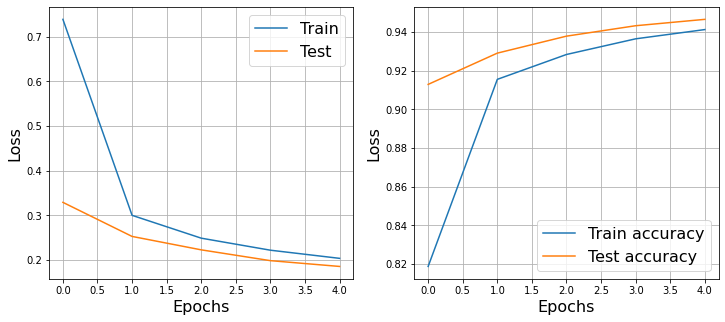

In [ ]:
network = ConvClassifier(image_size=28)
train(network, 5, 1e-4)

<i>3.1 Обучите сверточные сети с архитектурами (1) и (2). Какое качество удалось получить на тестовой выборке? Какой результат получался на полносвязной нейронной сети?</i>

In [18]:
# input -> 8 Conv 3x3 -> ReLU -> maxpool -> 16 Conv 3x3 -> ReLU -> ravel -> Linear -> LogSoftmax

channels = 1
image_size = 28

class ConvClassifier_16ch(nn.Module):
    def __init__(self, image_size):
        super().__init__()
        self.conv_layers = nn.Sequential(nn.Conv2d(channels, 8, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2), nn.Conv2d(8, 16, 3, padding=1), nn.ReLU())
        self.linear_layers = nn.Sequential(nn.Linear(16 * image_size//2*image_size//2, 10), nn.LogSoftmax(dim=1))
    
    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x

Epoch 4... (Train/Test) NLL: 0.079/0.069	Accuracy: 0.977/0.978


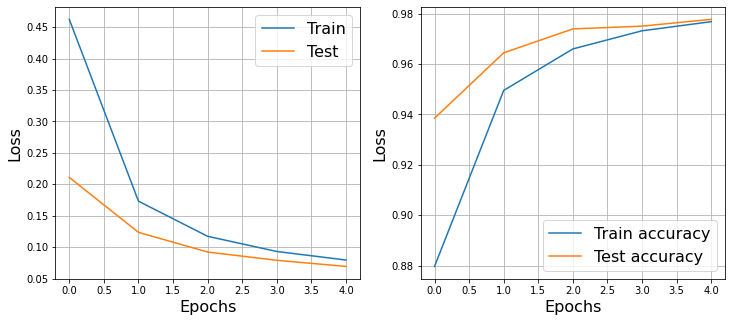

In [19]:
network = ConvClassifier_16ch(image_size=28)
train(network, 5, 1e-4)

In [22]:
# input -> 8 Conv 3x3 -> ReLU -> 16 Conv 3x3 -> ReLU -> maxpool -> 32 Conv 3x3 -> ravel -> Linear -> LogSoftmax

channels = 1
image_size = 28

class ConvClassifier_32ch(nn.Module):
    def __init__(self, image_size):
        super().__init__()
        self.conv_layers = nn.Sequential(nn.Conv2d(channels, 8, 3, padding=1), nn.ReLU(),nn.Conv2d(8, 16, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
                                         nn.Conv2d(16, 32, 3, padding=1))
        self.linear_layers = nn.Sequential(nn.Linear(32 * image_size//2*image_size//2, 10), nn.LogSoftmax(dim=1))
    
    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x

Epoch 4... (Train/Test) NLL: 0.069/0.059	Accuracy: 0.979/0.981


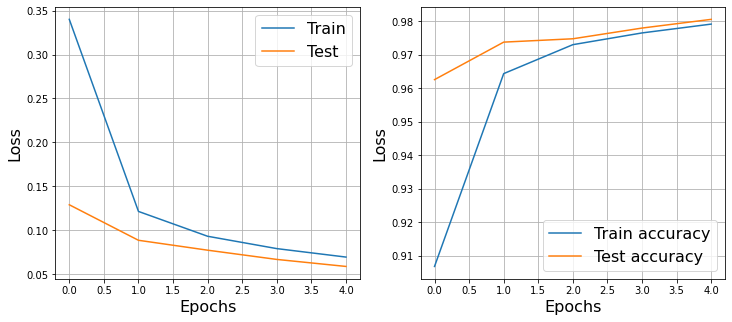

In [23]:
network = ConvClassifier_32ch(image_size=28)
train(network, 5, 1e-4)

<i>3.2 На каких объектах сеть ошибается сильнее всего? Нарисуйте эти объекты с правильными и предсказаными метками.</i>

In [26]:
wrong_X = []
correct_y = []
predicted_y = []
logits = []
for X, y in test_loader:
    prediction = network.forward(X).detach().numpy()
    prediction = np.exp(prediction)
    prediction /= prediction.sum(1, keepdims=True)
    for i in range(len(prediction)):
        if np.argmax(prediction[i]) != y[i]:
            wrong_X.append(X[i])
            correct_y.append(y[i])
            predicted_y.append(np.argmax(prediction[i]))
            logits.append(prediction[i][y[i]])
wrong_X = np.row_stack(wrong_X)
correct_y = np.row_stack(correct_y)[:, 0]
predicted_y = np.row_stack(predicted_y)[:, 0]
logits = np.row_stack(logits)[:, 0]

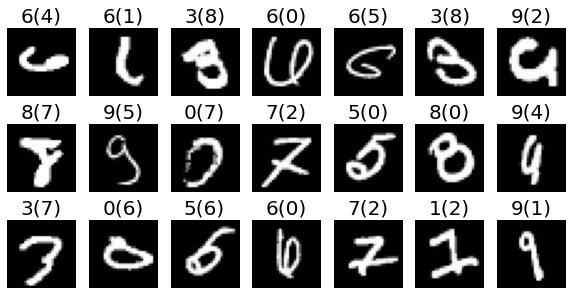

In [27]:
plt.figure(figsize=(10, 5))
order = np.argsort(logits)
for i in range(21):
    plt.subplot(3, 7, i+1)
    plt.imshow(wrong_X[order[i]].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title('{}({})'.format(correct_y[order[i]], predicted_y[order[i]]), fontsize=20)
    plt.axis('off')

<i>3.3 Поэкспериментируйте с различными архитектурами сверточных сетей. Смогли ли вы улучшить результат на тестовой выборке?</i>

Так как при количестве каналов в ввыходном тензоре, равном 32 наблюдалась лучше accuracy, чем при 16, то попробуем добавить еще нелинейностей и последний сверточный слой (input(32) - output(64))


In [30]:
# input -> 8 Conv 3x3 -> ReLU -> 16 Conv 3x3 -> ReLU -> maxpool -> 32 Conv 3x3 -> ReLU -> 64 conv 3x3 -> ravel -> Linear -> LogSoftmax

channels = 1
image_size = 28

class ConvClassifier_64ch(nn.Module):
    def __init__(self, image_size):
        super().__init__()
        self.conv_layers = nn.Sequential(nn.Conv2d(channels, 8, 3, padding=1), nn.ReLU(),nn.Conv2d(8, 16, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
                                         nn.Conv2d(16, 32, 3, padding=1), nn.ReLU(), nn.Conv2d(32, 64, 3, padding=1))
        self.linear_layers = nn.Sequential(nn.Linear(64 * image_size//2*image_size//2, 10), nn.LogSoftmax(dim=1))
    
    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x

Epoch 4... (Train/Test) NLL: 0.049/0.042	Accuracy: 0.985/0.986


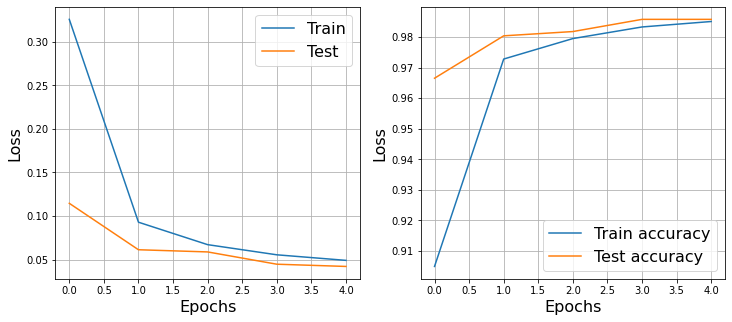

In [31]:
network = ConvClassifier_64ch(image_size=28)
train(network, 5, 1e-4)

#### Feedback (опционально)

Здесь вы можете оставить список опечаток из лекции или семинара:

Здесь вы можете оставить комментарии по лекции или семинару: